In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV




%load_ext autoreload
%autoreload 2

module_path = os.path.abspath(os.path.join( 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from nb_modules import model as mod

In [2]:
building_df = pd.read_pickle('data/pickles/building_df.pkl')

## Train Test Split for base line model

In [3]:
X_droplist = ['target','legal_ownership_status', 'land_surface_condition', 'foundation_type',
       'roof_type', 'ground_floor_type', 'other_floor_type', 'plan_configuration', 'position']

X = building_df.drop(columns=X_droplist)
y = building_df['target']

#performing train-test split on main dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.2)

#checking the shape of the training set and test set
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape,)
print("Test set - Features: ", X_test.shape, "Target: ",y_test.shape,)
print('============================================ ')
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

Training set - Features:  (609684, 46) Target:  (609684,)
Test set - Features:  (152422, 46) Target:  (152422,)
3    0.603185
1    0.217613
2    0.179203
Name: target, dtype: float64
3    0.602656
1    0.219188
2    0.178157
Name: target, dtype: float64


## BASELINE MODEL
Multiclass Logistic Regression

In [4]:
lr1 = LogisticRegression(solver='lbfgs',multi_class='multinomial', random_state=100)

lr1.fit(X_train, y_train)

y_pred_test = lr1.predict(X_test)
y_pred_train = lr1.predict(X_train)

# checking accuracy score
print('Test Accuracy score: ', round(metrics.accuracy_score(y_test, y_pred_test),4))
print('Train Accuracy score: ', round(metrics.accuracy_score(y_train, y_pred_train),4))
print('================================')
# checking f1 score
print('Test F1 score: ', round(metrics.f1_score(y_test, y_pred_test, average='weighted'),4))
print('Train F1 score: ', round(metrics.f1_score(y_train, y_pred_train, average='weighted'),4))
print('================================')
# checking recall score
print('Test Recall score: ', round(metrics.recall_score(y_test, y_pred_test, average='weighted'),4))
print('Train Recall score: ', round(metrics.recall_score(y_train, y_pred_train, average='weighted'),4))

Test Accuracy score:  0.6027
Train Accuracy score:  0.6032
Test F1 score:  0.4532
Train F1 score:  0.4539
Test Recall score:  0.6027
Train Recall score:  0.6032


In [5]:
mod_eval= {}
mod_eval['baseline_lr1']={'accuracy': .6027, 'f1':0.4532, 'recall': 0.6032}

## Feature Engineering

We have a lot of nominal variables that may best be turned to dummies. The corresponding *'num'* features will be added to the drop list to be removed from the main dataset to be used in modeling

In [6]:
dummy_1 = mod.dummify(building_df, 'ward_id')
dummy_2 = mod.dummify(building_df, 'land_surface_condition')
dummy_3 = mod.dummify(building_df, 'foundation_type')
dummy_4 = mod.dummify(building_df, 'roof_type')
dummy_5 = mod.dummify(building_df, 'ground_floor_type')
dummy_6 = mod.dummify(building_df, 'other_floor_type')
dummy_7 = mod.dummify(building_df, 'position')
dummy_8 = mod.dummify(building_df, 'plan_configuration')
dummy_9 = mod.dummify(building_df, 'legal_ownership_status')

Next, we drop all the dummified features, 

In [7]:
drop_list= ['ward_id', 'land_surface_condition', 'foundation_type',
       'roof_type', 'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration','legal_ownership_status', 'land_surface_condition_num', 
            'foundation_type_num', 'roof_type_num',
       'ground_floor_type_num', 'other_floor_type_num', 'position_num', 
            'plan_configuration_num', 'legal_ownership_status_num', 
            'has_secondary_use', 'has_geotechnical_risk']

In [8]:
building_df.drop(columns= drop_list, inplace=True)

In [9]:
df_list= [building_df, dummy_1 , dummy_2 , dummy_3 , dummy_4 , dummy_5 , dummy_6 , dummy_7 , dummy_8 , dummy_9]
for df in df_list:
    print(df.shape)


(762106, 36)
(762106, 18)
(762106, 2)
(762106, 4)
(762106, 2)
(762106, 4)
(762106, 3)
(762106, 3)
(762106, 9)
(762106, 3)


In [10]:
X = pd.concat(df_list, axis=1)

In [11]:
y = X['target']
X.drop(['target'], axis=1, inplace=True)

In [12]:
print(X.shape)
print(y.shape)

(762106, 83)
(762106,)


### Polynomial Features

In [103]:
# #Instantiating polynomial features object
# poly = PolynomialFeatures(degree=2, include_bias=False)

# # applying polynomial feature object to data
# poly_data = poly.fit_transform(X)

# #assigning feature names from main dataframe
# poly_columns = poly.get_feature_names(X.columns)

# #converting array to dataframe
# df_poly = pd.DataFrame(poly_data, columns = poly_columns)

In [104]:
# df_poly.shape

In [105]:
# np.sqrt(762106)

## Train Test Split - dataset after polynomial features

## Feature Selection using PCA

**PCA Step-by-step**
* It is important to center and standardize your data. PCA lives off of correlation and covariance of your data, and using wildly different scales could lead to inflated weights for the linear combination. Let's call this centered and standardized matrix Z.
* Calculate a covariance matrix of p x p where p responds to number of predictors.
* Calculate the eigenvectors and eigenvalues of the covariance matrix.
* Arrange the eigenvalues from largest to smallest. You should obtain p eigenvalues which correspond to number of components.
* Choose the amount of components you want to include based on number of variance explained.

## Train Test Split

In [13]:
#performing train-test split on main dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.4)

#checking the shape of the training set and test set
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape,)
print("Test set - Features: ", X_test.shape, "Target: ",y_test.shape,)
print('============================================ ')
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

Training set - Features:  (457263, 83) Target:  (457263,)
Test set - Features:  (304843, 83) Target:  (304843,)
3    0.603718
1    0.217566
2    0.178716
Name: target, dtype: float64
3    0.60212
1    0.21847
2    0.17941
Name: target, dtype: float64


## Class Imbalance
Going forward to tackle the class imbalance problem in the data, we will use a class weight dictionary to defince the class weight to be used in the models

In [14]:
round(y.value_counts(normalize=True)*100,2)

3    60.31
1    21.79
2    17.90
Name: target, dtype: float64

In [15]:
cw= {3: 20, 1: 35, 2: 45}

In [16]:
#concatenate our training data back together
training = pd.concat([X_train, y_train], axis=1)

In [17]:
# Separating the classes
grade1 = training[training['target']==1]
grade2 = training[training['target']==2]
grade3 = training[training['target']==3]
training['target'].value_counts()

3    276058
1     99485
2     81720
Name: target, dtype: int64

In [18]:
from sklearn.utils import resample

In [ ]:
x

In [19]:
downsampled_grade3 = resample(grade3,
                      replace=False,
                      n_samples = len(grade1)+30000,
                      random_state = 100)

In [20]:
downsampled_grade3.shape

(129485, 84)

In [21]:
downsampled = pd.concat([downsampled_grade3, grade1, grade2])

In [22]:
round(downsampled['target'].value_counts(normalize=True)*100,2)

3    41.68
1    32.02
2    26.30
Name: target, dtype: float64

In [23]:
y_train_dn = downsampled['target']
X_train_dn = downsampled.drop(columns = ['target'], axis= 1)
X_train_dn.shape

(310690, 83)

## Standardizing train and test

In [24]:
columns = X_train_dn.columns
scaler = MinMaxScaler()  
scaler.fit(X_train_dn)

X_train_scaled_values = scaler.transform(X_train_dn.values)  
X_test_scaled_values = scaler.transform(X_test.values)

X_train_scaled = X_train_dn.copy()
X_test_scaled = X_test.copy()

X_train_scaled[columns]= X_train_scaled_values
X_test_scaled[columns] = X_test_scaled_values

# Models

**Unweighted Multiclass Logistic Regression Classification**

In [141]:
lr2 = LogisticRegression(solver='saga',multi_class='multinomial', 
                                random_state=100, max_iter=10000, C=1e5,
                                verbose=1, n_jobs=-1)

lr2.fit(X_train_scaled, y_train_dn) 

# class predictions (not predicted probabilities)
y_pred_test = lr2.predict(X_test_scaled)
y_pred_train = lr2.predict(X_train_scaled)

# checking accuracy score
print('Test Accuracy score: ', round(metrics.accuracy_score(y_test, y_pred_test),4))
print('Train Accuracy score: ', round(metrics.accuracy_score(y_train_dn, y_pred_train),4))
print('================================')
# checking f1 score
print('Test F1 score: ', round(metrics.f1_score(y_test, y_pred_test, average='weighted'),4))
print('Train F1 score: ', round(metrics.f1_score(y_train_dn, y_pred_train, average='weighted'),4))
print('================================')
# checking recall score
print('Test Recall score: ', round(metrics.recall_score(y_test, y_pred_test, average='weighted'),4))
print('Train Recall score: ', round(metrics.recall_score(y_train_dn, y_pred_train, average='weighted'),4))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 47 epochs took 30 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   29.9s finished


Test Accuracy score:  0.6865
Train Accuracy score:  0.5919
Test F1 score:  0.6448
Train F1 score:  0.5369
Test Recall score:  0.6865
Train Recall score:  0.5919


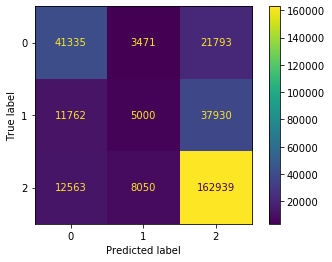

In [142]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_test)

cm_display = ConfusionMatrixDisplay(cm).plot()

              precision    recall  f1-score   support

           1       0.63      0.62      0.63     66599
           2       0.30      0.09      0.14     54692
           3       0.73      0.89      0.80    183552

    accuracy                           0.69    304843
   macro avg       0.55      0.53      0.52    304843
weighted avg       0.63      0.69      0.64    304843



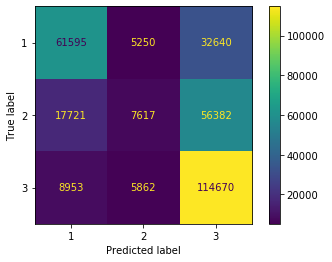

In [166]:
from sklearn.metrics import plot_confusion_matrix, classification_report

plot_confusion_matrix(lr2, X_train_scaled, y_train_dn)

print(classification_report(y_test, y_pred_test))

In [158]:
scoring = {'recall': mod.scorer_recall()}

In [161]:
lr = LogisticRegression(random_state=100, multi_class='multinomial', solver= 'saga' )
params = {'C':[0.1, 1, 5, 10], 'max_iter': [1000, 10000]}
gs_lr = GridSearchCV(lr, param_grid=params, scoring=scoring, cv=3, verbose=2, refit='recall', n_jobs=-1)

In [162]:
gs_lr.fit(X_train_scaled, y_train_dn)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  5.2min finished


GridSearchCV(cv=3,
             estimator=LogisticRegression(multi_class='multinomial',
                                          random_state=100, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 5, 10], 'max_iter': [1000, 10000]},
             refit='recall',
             scoring={'recall': make_scorer(recall_score_class)}, verbose=2)

In [167]:
gs_lr.best_params_

{'C': 0.1, 'max_iter': 1000}

In [168]:
lr2 = LogisticRegression(solver='saga',multi_class='multinomial', 
                                random_state=100, max_iter=1000, C=0.1,
                                verbose=2, n_jobs=-1)

lr2.fit(X_train_scaled, y_train_dn) 

# class predictions (not predicted probabilities)
y_pred_test = lr2.predict(X_test_scaled)
y_pred_train = lr2.predict(X_train_scaled)

# checking accuracy score
print('Test Accuracy score: ', round(metrics.accuracy_score(y_test, y_pred_test),4))
print('Train Accuracy score: ', round(metrics.accuracy_score(y_train_dn, y_pred_train),4))
print('================================')
# checking f1 score
print('Test F1 score: ', round(metrics.f1_score(y_test, y_pred_test, average='weighted'),4))
print('Train F1 score: ', round(metrics.f1_score(y_train_dn, y_pred_train, average='weighted'),4))
print('================================')
# checking recall score
print('Test Recall score: ', round(metrics.recall_score(y_test, y_pred_test, average='weighted'),4))
print('Train Recall score: ', round(metrics.recall_score(y_train_dn, y_pred_train, average='weighted'),4))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 17 epochs took 11 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.1s finished


Test Accuracy score:  0.6873
Train Accuracy score:  0.5918
Test F1 score:  0.6447
Train F1 score:  0.5359
Test Recall score:  0.6873
Train Recall score:  0.5918


In [25]:
lr2 = LogisticRegression(solver='lbfgs',multi_class='multinomial', 
                                random_state=100, max_iter=1000, C=0.1,
                                verbose=2, n_jobs=-1)

lr2.fit(X_train_scaled, y_train_dn) 

# class predictions (not predicted probabilities)
y_pred_test = lr2.predict(X_test_scaled)
y_pred_train = lr2.predict(X_train_scaled)

# checking accuracy score
print('Test Accuracy score: ', round(metrics.accuracy_score(y_test, y_pred_test),4))
print('Train Accuracy score: ', round(metrics.accuracy_score(y_train_dn, y_pred_train),4))
print('================================')
# checking f1 score
print('Test F1 score: ', round(metrics.f1_score(y_test, y_pred_test, average='weighted'),4))
print('Train F1 score: ', round(metrics.f1_score(y_train_dn, y_pred_train, average='weighted'),4))
print('================================')
# checking recall score
print('Test Recall score: ', round(metrics.recall_score(y_test, y_pred_test, average='weighted'),4))
print('Train Recall score: ', round(metrics.recall_score(y_train_dn, y_pred_train, average='weighted'),4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.6min finished


Test Accuracy score:  0.6873
Train Accuracy score:  0.5918
Test F1 score:  0.6447
Train F1 score:  0.5358
Test Recall score:  0.6873
Train Recall score:  0.5918


In [26]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train_scaled, y_train_dn)

y_pred_test= clf.predict(X_test_scaled)
y_pred_train = clf.predict(X_train_scaled)

# checking accuracy score
print('Test Accuracy score: ', round(metrics.accuracy_score(y_test, y_pred_test),4))
print('Train Accuracy score: ', round(metrics.accuracy_score(y_train_dn, y_pred_train),4))
print('================================')
# checking f1 score
print('Test F1 score: ', round(metrics.f1_score(y_test, y_pred_test, average='weighted'),4))
print('Train F1 score: ', round(metrics.f1_score(y_train_dn, y_pred_train, average='weighted'),4))
print('================================')
# checking recall score
print('Test Recall score: ', round(metrics.recall_score(y_test, y_pred_test, average='weighted'),4))
print('Train Recall score: ', round(metrics.recall_score(y_train_dn, y_pred_train, average='weighted'),4))

Test Accuracy score:  0.6647
Train Accuracy score:  0.5697
Test F1 score:  0.6355
Train F1 score:  0.5298
Test Recall score:  0.6647
Train Recall score:  0.5697


In [32]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB( )
clf.fit(X_train_dn, y_train_dn)

y_pred_test= clf.predict(X_test)
y_pred_train = clf.predict(X_train_dn)

# checking accuracy score
print('Test Accuracy score: ', round(metrics.accuracy_score(y_test, y_pred_test),4))
print('Train Accuracy score: ', round(metrics.accuracy_score(y_train_dn, y_pred_train),4))
print('================================')
# checking f1 score
print('Test F1 score: ', round(metrics.f1_score(y_test, y_pred_test, average='weighted'),4))
print('Train F1 score: ', round(metrics.f1_score(y_train_dn, y_pred_train, average='weighted'),4))
print('================================')
# checking recall score
print('Test Recall score: ', round(metrics.recall_score(y_test, y_pred_test, average='weighted'),4))
print('Train Recall score: ', round(metrics.recall_score(y_train_dn, y_pred_train, average='weighted'),4))

Test Accuracy score:  0.6643
Train Accuracy score:  0.5661
Test F1 score:  0.6314
Train F1 score:  0.5223
Test Recall score:  0.6643
Train Recall score:  0.5661


In [34]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train, y_train)

y_pred_test= clf.predict(X_test)
y_pred_train = clf.predict(X_train)

# checking accuracy score
print('Test Accuracy score: ', round(metrics.accuracy_score(y_test, y_pred_test),4))
print('Train Accuracy score: ', round(metrics.accuracy_score(y_train, y_pred_train),4))
print('================================')
# checking f1 score
print('Test F1 score: ', round(metrics.f1_score(y_test, y_pred_test, average='weighted'),4))
print('Train F1 score: ', round(metrics.f1_score(y_train, y_pred_train, average='weighted'),4))
print('================================')
# checking recall score
print('Test Recall score: ', round(metrics.recall_score(y_test, y_pred_test, average='weighted'),4))
print('Train Recall score: ', round(metrics.recall_score(y_train, y_pred_train, average='weighted'),4))

Test Accuracy score:  0.6819
Train Accuracy score:  0.6827
Test F1 score:  0.6232
Train F1 score:  0.6245
Test Recall score:  0.6819
Train Recall score:  0.6827


              precision    recall  f1-score   support

           1       0.66      0.52      0.58     66599
           2       0.28      0.05      0.08     54692
           3       0.70      0.93      0.80    183552

    accuracy                           0.68    304843
   macro avg       0.55      0.50      0.49    304843
weighted avg       0.62      0.68      0.62    304843



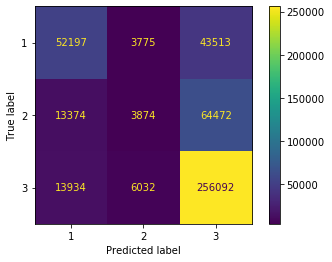

In [35]:
from sklearn.metrics import plot_confusion_matrix, classification_report

plot_confusion_matrix(clf, X_train, y_train)

print(classification_report(y_test, y_pred_test))

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=100)

cross_val_score(clf, X_train_scaled, y_train_dn, cv=10)

array([0.63149763, 0.62924458, 0.62985613, 0.63368631, 0.63265635,
       0.63017799, 0.63152982, 0.6304033 , 0.63519907, 0.63696933])

TypeError: score() missing 2 required positional arguments: 'X' and 'y'